
### Fetch + merge
→ merged: 37008 cells × 33538 genes

### QC filtering

### scvi-tools dimensionality reduction


/home/jovyan/.local/lib/python3.12/site-packages/scvi/dataloaders/_data_splitting.py:258: UserWarning: 1 cells moved from training set to validation set. if you want to avoid it please use train_size parameter during train.
  self.n_train, self.n_val = validate_data_split(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/jovyan/.local/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

/home/jovyan/.local/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.
`Trainer.fit` stopped: `max_epochs=400` reached.


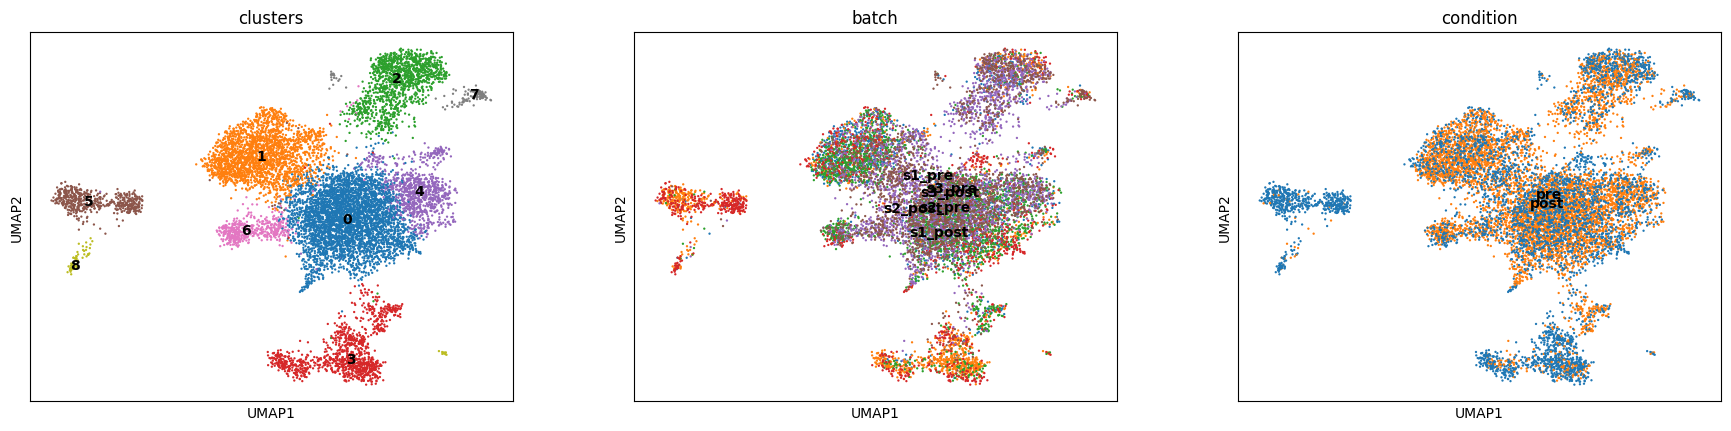

Silhouette (X_scVI) = 0.080
Initiating cluster annotation with marker database...
Annotation complete.


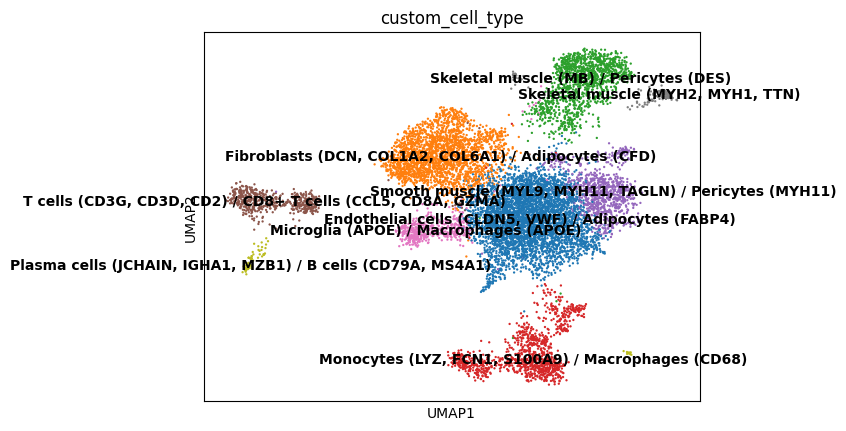


### differential expression (pre vs post)

=== Top markers per cluster ===
  Cluster 0:  AQP1, MGLL, NRP1, ITGA6, CA4, CD36
  Cluster 1:  DCN, GSN, COL6A2, COL1A2, COL6A1, SERPINF1
  Cluster 2:  MYL3, MYL2, TNNT1, TNNC1, DWORF, TNNI1
  Cluster 3:  AIF1, C5AR1, CYBB, CTSS, LST1, CXCL8
  Cluster 4:  JAG1, HES4, GUCY1A1, TSC22D1, GJA4, CASQ2
  Cluster 5:  CD3G, CD3D, ARL4C, CD2, KLRB1, TRBC1
  Cluster 6:  APOE, APOC1, DAG1, TUBB2B, MYF5, SPATS2L
  Cluster 7:  TNNI2, TNNT3, TPM1, MYLPF, MYH2, TNNC2
  Cluster 8:  IGHM, IGLC2, IGKC, IGLC3, CD79A, GOLGA6L9

→ drawing dot-plot


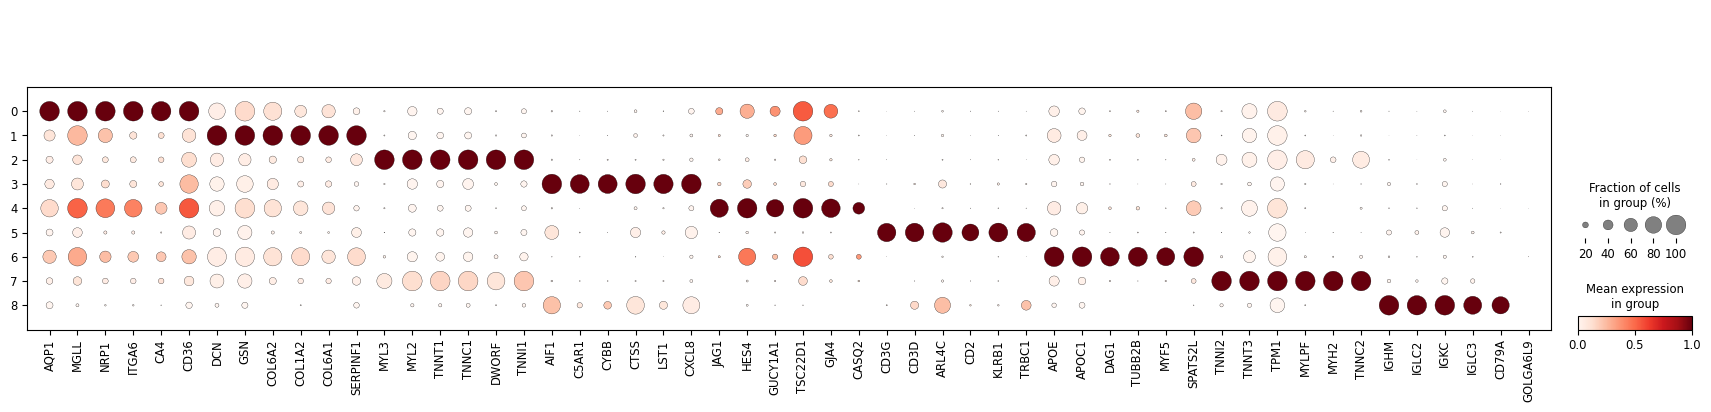


→ drawing heat-map


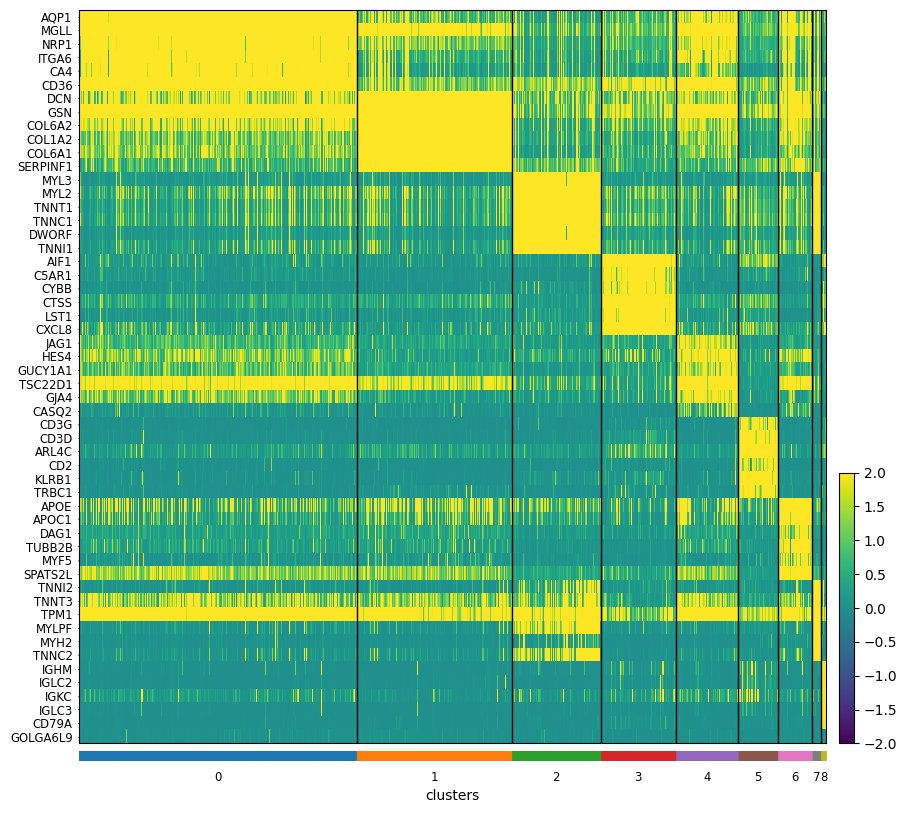


### pseudo-bulk


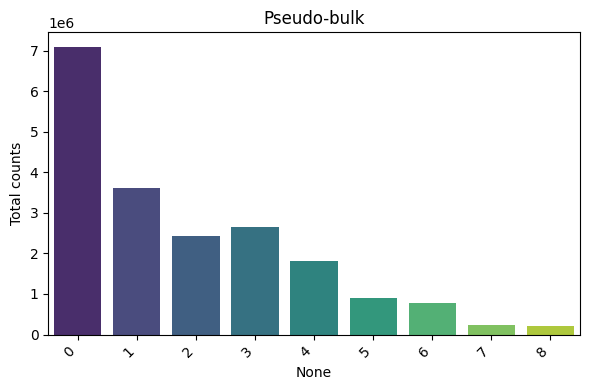

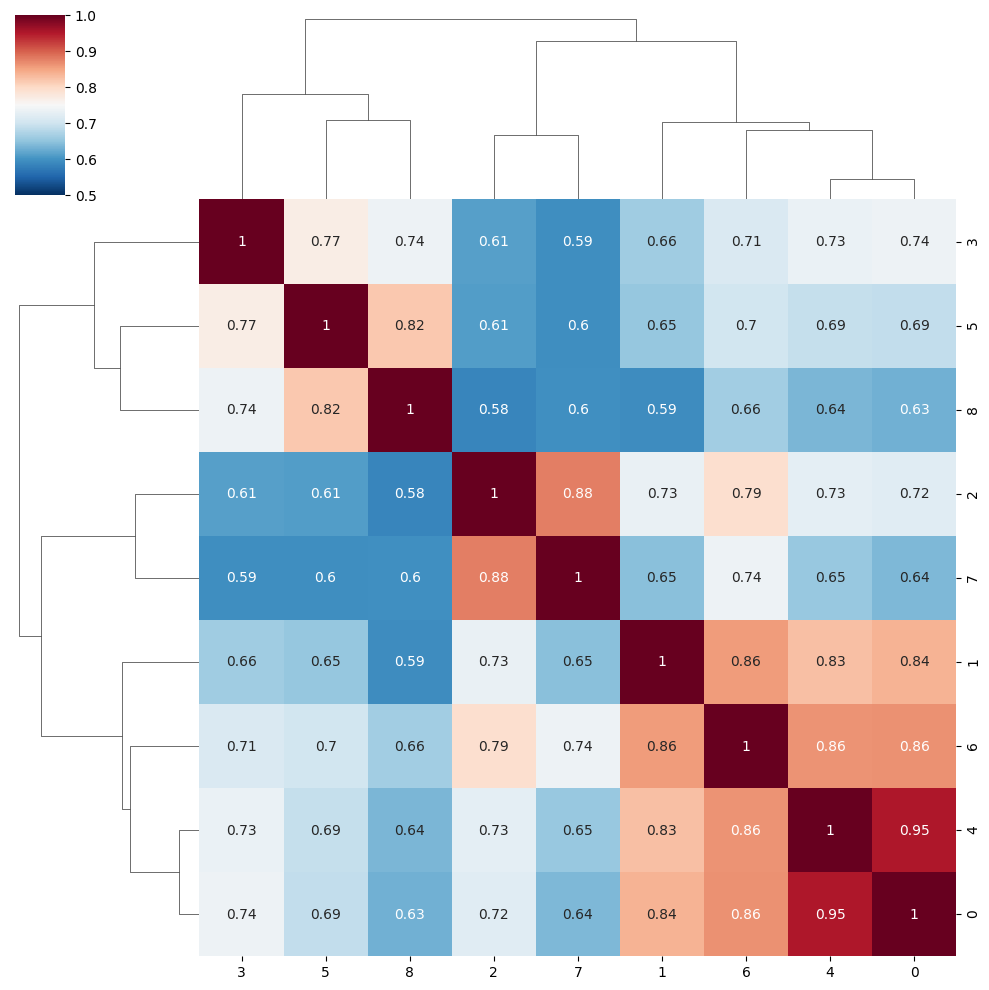


### pseudotime (py_monocle)


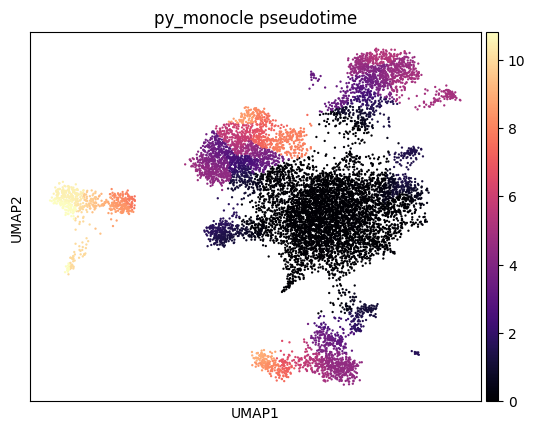


✔ pipeline finished – results saved to PBMC_scvi_monocle.h5ad


In [26]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
###############################################################################
# PBMC SINGLE-CELL PIPELINE  –  scvi-tools + py_monocle version (stand-alone) #
#  • GEO (10x-style) download / merge                                         #
#  • QC / filtering                                                           #
#  • Dimensionality reduction with scvi-tools (X_scVI)                        #
#  • Leiden clustering, marker detection, custom annotation                   #
#  • Pseudo-bulk utilities                                                    #
#  • Pseudotime with py_monocle                                               #
###############################################################################
# Requirements (conda or pip): scanpy anndata scvi-tools py-monocle seaborn   #
#   matplotlib pandas numpy scipy scikit-learn                                #
###############################################################################

import os, gzip, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import List, Dict
from urllib.request import urlretrieve

import scanpy as sc
import anndata as an
import scvi
import py_monocle                       # pip install py-monocle
from sklearn.metrics import silhouette_score
import scipy.sparse as sp

warnings.filterwarnings("ignore", category=FutureWarning)


# ════════════════════════════════════════════════════════════════════════════
# 1) GEO 10x-format download & merge  (UNCHANGED)
# ════════════════════════════════════════════════════════════════════════════
def fetch_and_merge_10x_datasets(sample_records: List[Dict[str, str]],
                                 dest_folder: str = "data") -> an.AnnData:
    """
    Download each GSM sample’s *_matrix.mtx.gz, *_barcodes.tsv.gz,
    *_features.tsv.gz from GEO, decompress, read, and concatenate into
    one AnnData object.
    """
    os.makedirs(dest_folder, exist_ok=True)
    adata_list, labels = [], []

    for rec in sample_records:
        acc, pre, lbl = rec['accession'], rec['file_prefix'], rec['label']
        files = {"matrix": f"{pre}_matrix.mtx",
                 "barcodes": f"{pre}_barcodes.tsv",
                 "features": f"{pre}_features.tsv"}
        local = {k: Path(dest_folder)/v for k, v in files.items()}

        # download & decompress if necessary
        for kind, tgt in local.items():
            gz = tgt.with_suffix(tgt.suffix + ".gz")
            if not tgt.exists():
                if not gz.exists():
                    url = (f"https://www.ncbi.nlm.nih.gov/geo/download/?acc={acc}"
                           f"&format=file&file={pre}_{kind}.{tgt.suffix[1:]}.gz")
                    url = url.replace("_", "%5F").replace(".", "%2E")
                    print(f"⇣ downloading {gz.name}")
                    urlretrieve(url, gz)
                print(f"  ↪ decompressing {gz.name}")
                with gzip.open(gz, 'rb') as f_in, open(tgt, 'wb') as f_out:
                    f_out.write(f_in.read())

        # build AnnData
        ad = sc.read_mtx(local['matrix']).T
        bar = pd.read_csv(local['barcodes'], header=None)[0]
        ad.obs_names = [f"{lbl}_{b}" for b in bar]

        feat = pd.read_csv(local['features'], sep='\t', header=None)
        ad.var_names = feat[0]
        ad.var['gene_symbols'] = feat[1].values
        if feat.shape[1] > 2:
            ad.var['feature_type'] = feat[2].values

        # copy metadata columns
        for k, v in rec.items():
            if k not in ['accession', 'file_prefix']:
                ad.obs[k] = v

        adata_list.append(ad)
        labels.append(lbl)

    adata = an.concat(adata_list, axis=0, join='outer', label='batch', keys=labels)
    adata.obs_names_make_unique()

    # replace Ensembl->symbol using first feature file
    ens2sym = dict(zip(feat[0], feat[1]))
    adata.var_names = [ens2sym.get(g, g) for g in adata.var_names]
    adata.var_names_make_unique()

    adata.var['mt'] = adata.var_names.str.upper().str.startswith('MT-')
    print(f"→ merged: {adata.n_obs} cells × {adata.n_vars} genes")
    return adata


# ════════════════════════════════════════════════════════════════════════════
# 2) Cluster-annotation helper  (UPDATED)
# ════════════════════════════════════════════════════════════════════════════
def assign_cell_identity_with_markers(adata, top_n=50):
    """
    Annotates cluster identities using a custom dictionary of cell-type markers.
    Uses rank_genes_groups output and matches the user’s marker list.
    """
    print("Initiating cluster annotation with marker database...")

    # ---------------- marker dictionary you provided ----------------
    marker_db = {
        # Immune
        'T cells': ['CD3D', 'CD3E', 'CD3G', 'CD2', 'CD7', 'IL7R', 'LCK', 'CD28'],
        'CD4+ T cells': ['CD4', 'IL7R', 'CCR7', 'LEF1', 'TCF7', 'MAL'],
        'CD8+ T cells': ['CD8A', 'CD8B', 'GZMK', 'GZMA', 'CCL5', 'GNLY'],
        'Regulatory T cells': ['FOXP3', 'IL2RA', 'CTLA4', 'TIGIT', 'IKZF2'],
        'B cells': ['CD19', 'MS4A1', 'CD79A', 'CD79B', 'HLA-DRA', 'CD74'],
        'Plasma cells': ['JCHAIN', 'MZB1', 'SSR4', 'XBP1', 'IGHA1', 'IGHG1'],
        'NK cells': ['NCAM1', 'NKG7', 'GNLY', 'KLRD1', 'KLRF1', 'FCGR3A'],
        'Monocytes': ['CD14', 'LYZ', 'VCAN', 'S100A9', 'S100A8', 'FCN1'],
        'Macrophages': ['CD68', 'MSR1', 'MARCO', 'VSIG4', 'C1QA', 'C1QB', 'APOE'],
        'Dendritic cells': ['CLEC9A', 'CLEC10A', 'CD1C', 'FCER1A', 'ITGAX', 'IRF8'],
        'Neutrophils': ['ELANE', 'MPO', 'S100A8', 'S100A9', 'CEACAM8', 'FCGR3B'],
        'Mast cells': ['CPA3', 'TPSAB1', 'TPSB2', 'MS4A2', 'HDC', 'KIT'],
        # Endothelial
        'Endothelial cells': ['PECAM1', 'VWF', 'CDH5', 'CLDN5', 'SELE', 'KDR', 'TEK'],
        'Lymphatic endothelial': ['PROX1', 'PDPN', 'FLT4', 'CCL21', 'LYVE1'],
        'Pericytes': ['RGS5', 'PDGFRB', 'DES', 'ACTA2', 'MYH11', 'MCAM', 'CSPG4'],
        # Epithelial
        'Epithelial cells': ['EPCAM', 'KRT8', 'KRT18', 'KRT19', 'CDH1', 'CLDN4', 'CLDN7'],
        # Stromal / Mesenchymal
        'Fibroblasts': ['DCN', 'LUM', 'COL1A1', 'COL1A2', 'COL3A1', 'COL6A1', 'PDGFRA', 'FAP'],
        'Smooth muscle': ['ACTA2', 'TAGLN', 'MYH11', 'CNN1', 'DES', 'TPM2', 'MYL9'],
        'Skeletal muscle': ['MYH1', 'MYH2', 'ACTA1', 'TTN', 'MYBPC1', 'CKM', 'MB'],
        'Adipocytes': ['ADIPOQ', 'LEP', 'FABP4', 'PLIN1', 'CFD', 'PPARG'],
        # Other specialised cell types
        'Neurons': ['MAP2', 'RBFOX3', 'TUBB3', 'SYP', 'SNAP25', 'NEFL', 'NEFM'],
        'Oligodendrocytes': ['MBP', 'MOG', 'MAG', 'PLP1', 'OLIG1', 'OLIG2'],
        'Astrocytes': ['GFAP', 'AQP4', 'SLC1A3', 'SLC1A2', 'ALDH1L1'],
        'Microglia': ['CX3CR1', 'P2RY12', 'ITGAM', 'TMEM119', 'TREM2', 'APOE'],
        'Hepatocytes': ['ALB', 'APOB', 'HP', 'FGA', 'FGB', 'APOA1', 'TTR'],
        'Erythrocytes': ['HBA1', 'HBA2', 'HBB', 'ALAS2', 'GYPA', 'SLC4A1'],
        'Interferon-responsive': ['ISG15', 'IFI6', 'IFI27', 'IFIT1', 'IFIT3', 'MX1', 'OAS1']
    }

    # ---------------- rest of the function (unchanged) ----------------
    marker_to_ct = {}
    for ct, genes in marker_db.items():
        for g in genes:
            marker_to_ct.setdefault(g, []).append(ct)

    clusters = adata.uns['rank_genes_groups']['names'].dtype.names
    cluster_id_to_annotation = {}

    for cluster in clusters:
        candidate_markers = []
        for i in range(min(top_n, len(adata.uns['rank_genes_groups']['names'][cluster]))):
            m_name = adata.uns['rank_genes_groups']['names'][cluster][i]
            score = adata.uns['rank_genes_groups']['scores'][cluster][i]
            pval  = adata.uns['rank_genes_groups']['pvals'][cluster][i]
            if pval < 0.05:
                candidate_markers.append((m_name, score, i))

        matching = {}
        for m_name, score, rank in candidate_markers:
            if m_name in marker_to_ct:
                for ct in marker_to_ct[m_name]:
                    matching.setdefault(ct, []).append((m_name, score, rank))

        ct_scores = {}
        for ct, info in matching.items():
            comb  = sum([x[1] * (1 - x[2]/top_n) for x in info])
            prop  = len(info) / len(marker_db[ct])
            ct_scores[ct] = (comb * (1 + prop), [x[0] for x in info])

        if ct_scores:
            best = sorted(ct_scores.items(), key=lambda x: x[1][0], reverse=True)[:2]
            txt  = " / ".join(f"{ct} ({', '.join(m[:3])})" for ct, (_, m) in best)
            cluster_id_to_annotation[cluster] = txt
        else:
            fallback = [x[0] for x in candidate_markers[:3]] or ["NoSigMarkers"]
            cluster_id_to_annotation[cluster] = f"Unknown (Top: {', '.join(fallback)})"

    # NOTE: expects 'clusters' column (see step-2 below)
    adata.obs['custom_cell_type'] = adata.obs['clusters'].map(cluster_id_to_annotation)
    print("Annotation complete.")
    return cluster_id_to_annotation

# ════════════════════════════════════════════════════════════════════════════
# 3) Display leading markers  (UNCHANGED MINOR CUT)
# ════════════════════════════════════════════════════════════════════════════
def display_leading_markers(adata, n_genes=10):
    cl = adata.obs['leiden'].unique().tolist()
    genes = []
    for c in cl:
        genes += adata.uns['rank_genes_groups']['names'][c][:n_genes].tolist()
    genes = list(dict.fromkeys(genes))[:50]
    sc.pl.dotplot(adata, genes, groupby='leiden', layer='norm_scvi')
    sc.pl.heatmap(adata, genes, groupby='leiden', layer='norm_scvi', swap_axes=True)

# ════════════════════════════════════════════════════════════════════════════
# 4) DE between conditions (UNCHANGED)
# ════════════════════════════════════════════════════════════════════════════
def compare_clusters_by_condition(adata, cluster_key='leiden',
                                  condition_key='condition',
                                  p_cut=0.05, min_cell_threshold=3):
    conds = adata.obs[condition_key].unique()
    if len(conds) != 2:
        raise ValueError("condition_key must have exactly 2 groups")
    a, b = conds
    summary = {}
    for cl in adata.obs[cluster_key].unique():
        sub = adata[adata.obs[cluster_key] == cl].copy()
        counts = sub.obs[condition_key].value_counts()
        if counts.get(a, 0) < min_cell_threshold or counts.get(b, 0) < min_cell_threshold:
            continue
        sc.tl.rank_genes_groups(sub, groupby=condition_key, groups=[b],
                                reference=a, layer='norm_scvi', method='wilcoxon')
        df = sc.get.rank_genes_groups_df(sub, group=b)
        sig = df[df.pvals_adj < p_cut]
        summary[cl] = sig
    return summary

# ════════════════════════════════════════════════════════════════════════════
# 5) Pseudo-bulk utils  (UNCHANGED)
# ════════════════════════════════════════════════════════════════════════════
def create_pseudobulk_counts(adata: an.AnnData, groupby: str = "leiden",
                             layer: str = 'counts') -> pd.DataFrame:
    mat = adata.layers[layer] if layer else adata.X
    if not isinstance(mat, np.ndarray):
        mat = mat.toarray()
    groups = adata.obs[groupby]
    uniq = groups.unique()
    out = pd.DataFrame(0, index=adata.var_names, columns=uniq)
    for g in uniq:
        out[g] = mat[groups == g].sum(0)
    return out

def plot_pseudobulk_counts(df: pd.DataFrame):
    # barplot
    plt.figure(figsize=(6,4))
    sns.barplot(x=df.columns, y=df.sum(), palette='viridis')
    plt.xticks(rotation=45, ha='right'); plt.ylabel('Total counts'); plt.title('Pseudo-bulk')
    plt.tight_layout(); plt.show()
    # correlation heatmap
    corr = np.log1p(df).corr()
    sns.clustermap(corr, annot=True, cmap='RdBu_r', vmin=0.5, vmax=1)
    plt.show()

# ════════════════════════════════════════════════════════════════════════════
# 6) Basic QC filter  (NEW)
# ════════════════════════════════════════════════════════════════════════════
def basic_qc(adata: an.AnnData,
             min_genes=300, min_cells=20,
             max_mito=15, min_counts=1_000, max_counts=15_000):
    """
    Add standard QC columns (incl. pct_counts_mt) and filter cells / genes.
    """
    # make sure the mt mask exists
    if 'mt' not in adata.var.columns:
        adata.var['mt'] = adata.var_names.str.upper().str.startswith('MT-')

    # calculate QC metrics, including mito percentage
    sc.pp.calculate_qc_metrics(
        adata,
        qc_vars=['mt'],        # <-- this line is the critical fix
        percent_top=None,
        inplace=True
    )

    # cell-level filters
    adata = adata[
        (adata.obs.n_genes_by_counts >= min_genes) &
        (adata.obs.pct_counts_mt     <= max_mito) &
        (adata.obs.total_counts      >= min_counts) &
        (adata.obs.total_counts      <= max_counts)
    ].copy()

    # gene-level filter
    sc.pp.filter_genes(adata, min_cells=min_cells)
    return adata

# ════════════════════════════════════════════════════════════════════════════
# 7) scvi latent + UMAP  (NEW)
# ════════════════════════════════════════════════════════════════════════════
def run_scvi(adata: an.AnnData, batch_key='batch', n_latent=30):
    if 'counts' not in adata.layers:
        adata.layers['counts'] = adata.X.copy()
    scvi.model.SCVI.setup_anndata(adata, layer='counts', batch_key=batch_key)
    vae = scvi.model.SCVI(adata, n_latent=n_latent)
    vae.train(max_epochs=400, check_val_every_n_epoch=50)
    adata.obsm['X_scVI'] = vae.get_latent_representation()
    adata.layers['norm_scvi'] = vae.get_normalized_expression(library_size=1e4)
    sc.pp.neighbors(adata, use_rep='X_scVI')
    sc.tl.umap(adata)
    return adata

# ════════════════════════════════════════════════════════════════════════════
# 8) py_monocle pseudotime  (NEW)
# ════════════════════════════════════════════════════════════════════════════
def run_monocle_pseudotime(adata: an.AnnData, root_cluster='0',
                           cluster_key='clusters', k_nn=25):
    if 'X_umap' not in adata.obsm:
        raise ValueError("UMAP not found – run_scvi() first.")
    root_idx = np.where(adata.obs[cluster_key].values == root_cluster)[0]
    ptime = py_monocle.pseudotime(
        matrix      = adata.obsm['X_umap'],
        root_cells  = root_idx,
        clusters    = adata.obs[cluster_key].values,
        k_nn        = k_nn,
        prune       = True,
        return_cell_states=False
    )
    adata.obs['pseudotime'] = ptime
    sc.pl.umap(adata, color='pseudotime', cmap='magma', title='py_monocle pseudotime')
    return adata

# ════════════════════════════════════════════════════════════════════════════
#   TOP-MARKER SUMMARY  +  HEAT-MAP
# ════════════════════════════════════════════════════════════════════════════
def top_markers_heatmap(
        adata: an.AnnData,
        n_markers: int = 6,          # number of genes per cluster
        groupby: str = "clusters",
        layer: str = "norm_scvi",
        show: bool = True):
    """
    • Uses the existing `rank_genes_groups` output in `adata.uns`.
    • Returns a tidy DataFrame of the top `n_markers` genes per cluster
      and optionally draws a heat-map & dot-plot.
    """
    if "rank_genes_groups" not in adata.uns:
        raise ValueError("Run `sc.tl.rank_genes_groups` first!")

    # --------------------------------------------------
    # gather top-N genes per cluster into one DataFrame
    # --------------------------------------------------
    df_all = sc.get.rank_genes_groups_df(adata, group=None)
    top_df = (
        df_all.sort_values(["group", "pvals_adj"])
              .groupby("group")
              .head(n_markers)
              .reset_index(drop=True)
    )
    # print to screen
    print("\n=== Top markers per cluster ===")
    for cl in sorted(top_df.group.unique(), key=int):
        genes = top_df[top_df.group == cl].names.tolist()
        print(f"  Cluster {cl}:  {', '.join(genes)}")

    # --------------------------------------------------
    # unique gene list (preserve cluster order)
    # --------------------------------------------------
    gene_order = []
    for cl in sorted(top_df.group.unique(), key=int):
        gene_order.extend(top_df[top_df.group == cl].names.tolist())
    gene_order = list(dict.fromkeys(gene_order))   # de-duplicate

    # --------------------------------------------------
    # plots
    # --------------------------------------------------
    if show:
        print("\n→ drawing dot-plot")
        sc.pl.dotplot(
            adata,
            var_names=gene_order,
            groupby=groupby,
            layer=layer,
            dendrogram=False,
            expression_cutoff=1,
            standard_scale="var"
        )

        print("\n→ drawing heat-map")
        sc.pl.heatmap(
            adata,
            var_names=gene_order,
            groupby=groupby,
            layer=layer,
            swap_axes=True,
            vmin=-2, vmax=2,                # change colour limits here
            cmap="viridis",
            show_gene_labels=True
        )

    return top_df


# ════════════════════════════════════════════════════════════════════════════
# 9) MAIN
# ════════════════════════════════════════════════════════════════════════════
if __name__ == "__main__":

    sample_data = [
        {'accession': 'GSM6611295', 'file_prefix': 'GSM6611295_P15306_5001',
         'condition': 'pre',  'subject': '1', 'label': 's1_pre'},
        {'accession': 'GSM6611296', 'file_prefix': 'GSM6611296_P15306_5002',
         'condition': 'post', 'subject': '1', 'label': 's1_post'},
        {'accession': 'GSM6611297', 'file_prefix': 'GSM6611297_P14601_4004',
         'condition': 'pre',  'subject': '2', 'label': 's2_pre'},
        {'accession': 'GSM6611298', 'file_prefix': 'GSM6611298_P14601_4005',
         'condition': 'post', 'subject': '2', 'label': 's2_post'},
        {'accession': 'GSM6611299', 'file_prefix': 'GSM6611299_P15306_5003',
         'condition': 'pre',  'subject': '3', 'label': 's3_pre'},
        {'accession': 'GSM6611300', 'file_prefix': 'GSM6611300_P15306_5004',
         'condition': 'post', 'subject': '3', 'label': 's3_post'},
    ]

    # 1) download + merge
    print("\n### Fetch + merge")
    adata = fetch_and_merge_10x_datasets(sample_data)

    # 2) QC
    print("\n### QC filtering")
    adata = basic_qc(adata)

    # 3) scvi latent / UMAP
    print("\n### scvi-tools dimensionality reduction")
    adata = run_scvi(adata)

    # 4) Leiden clustering
    sc.tl.leiden(adata, resolution=0.5, key_added='clusters')
    sc.pl.umap(adata, color=['clusters', 'batch', 'condition'], legend_loc='on data')
    sil = silhouette_score(adata.obsm['X_scVI'], adata.obs['clusters'])
    print(f"Silhouette (X_scVI) = {sil:.3f}")

    # 5) marker detection + annotation
    # rank genes groups
    sc.tl.rank_genes_groups(adata, groupby='clusters',
                        layer='norm_scvi', method='wilcoxon')    
    assign_cell_identity_with_markers(adata)
    sc.pl.umap(adata, color='custom_cell_type', legend_loc='on data')

    # 6) intra-cluster DE pre vs post
    print("\n### differential expression (pre vs post)")
    de_results = compare_clusters_by_condition(adata,
                                           cluster_key='clusters',
                                           min_cell_threshold=5)    
    os.makedirs("de_results", exist_ok=True)
    for cl, df in de_results.items():
        if df is not None and not df.empty:
            df.to_csv(f"de_results/cluster_{cl}_pre_vs_post.csv", index=False)
    
    # after you already ran:
    #   sc.tl.rank_genes_groups(adata, groupby='clusters', layer='norm_scvi')
    top_df = top_markers_heatmap(
    adata,
    n_markers=6,        # top-6 genes per cluster
    groupby='clusters',
    layer='norm_scvi')
    
    # save the table if you wish
    top_df.to_csv("top_markers_by_cluster.csv", index=False)

    # 7) pseudo-bulk
    print("\n### pseudo-bulk")
    pb = create_pseudobulk_counts(adata, groupby='clusters')
    pb.to_csv("pseudobulk_by_cluster.csv")
    plot_pseudobulk_counts(pb)

    # 8) pseudotime
    print("\n### pseudotime (py_monocle)")
    adata = run_monocle_pseudotime(adata, root_cluster='0')

    # 9) save
    adata.write("PBMC_scvi_monocle.h5ad")
    print("\n✔ pipeline finished – results saved to PBMC_scvi_monocle.h5ad")